Задача 1
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-09-12 по 2023-09-18. Ваша задача как аналитика – оценить эффективность этого мероприятия.

1-Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложите хотя бы 5 метрик.

2-Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.

3-Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы.
Формат сдачи задания – merge request в GitLab с ноутбуком, где выполнены вычисления (формат .ipynb).

1-Выбранные метрики для анализа флешмоба. (Все метрики расчитываются по дням):

    -Количество уникальных пользователей (uniq_users)
    -Количество новых пользователей (uniq_users_per_day)
    -Среднее количество лайков на 1 пользователя (likes_per_user)
    -общ.кол-во. лайков /общ.кол-во. просмотров (ctr)
    -Количество уникальных постов (uniq_posts)
    -Количество новых постов (uniq_posts_per_day)
    -Среднее количество лайков на 1 пост (likes_per_post)

In [1]:
#Загружаем библиотеки
import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact

import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az 

2023-10-13 11:53:58.204083: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 11:53:59.322957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 11:53:59.326351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 11:54:03.429074: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Параметры соединения
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230920',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
#Запрос
query = '''
WITH 
UUPD AS 
(SELECT first_date,
  uniq(user_id) AS uniq_users_per_day 
FROM 
(SELECT user_id, MIN (toDate(time)) AS first_date
FROM simulator_20230920.feed_actions 
GROUP BY user_id
HAVING  toDate(time) BETWEEN '2023-08-21' AND '2023-09-27')
GROUP BY first_date
HAVING  first_date > '2023-08-21'),

UPPD AS 
(SELECT first_date,
  uniq(post_id) AS uniq_posts_per_day 
FROM 
(SELECT post_id, MIN (toDate(time)) AS first_date
FROM simulator_20230920.feed_actions 
GROUP BY post_id
HAVING  toDate(time) BETWEEN '2023-08-21' AND '2023-09-27')
GROUP BY first_date
HAVING  first_date > '2023-08-21'),

Main AS
(SELECT toDate(time) AS date,
  uniq(user_id) AS uniq_users,
  countIf(action = 'like')/uniq_users AS likes_per_user,
  countIf(action = 'like')/ countIf(action = 'view') AS ctr,
  uniq(post_id) AS uniq_posts,
  countIf(action = 'like')/uniq_posts AS likes_per_post
FROM simulator_20230920.feed_actions 
WHERE toDate(time) BETWEEN '2023-08-22' AND '2023-09-27'
GROUP BY date)

SELECT date, 
  uniq_users,
  uniq_users_per_day,
  likes_per_user,
  ctr,
  uniq_posts,
  uniq_posts_per_day,
  likes_per_post
FROM Main, UUPD, UPPD 
WHERE Main.date=  UUPD.first_date  AND UUPD.first_date = UPPD.first_date
'''
# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection, index_col=['date'])
df.head()

,uniq_users,uniq_users_per_day,likes_per_user,ctr,uniq_posts,uniq_posts_per_day,likes_per_post
date,,,,,,,
2023-08-22,10814,7398,8.060107,0.206219,217,78,401.668203
2023-08-23,11567,6309,8.417740,0.209397,209,60,465.875598
2023-08-24,11739,5020,7.738905,0.211728,193,50,470.709845
2023-08-25,12501,4551,5.868491,0.206864,177,58,414.474576
2023-08-26,12597,3675,6.232198,0.213408,180,72,436.150000


In [4]:
# Разграничим переоды действия флешмоба
befor_flashmob = ['2023-08-22', '2023-09-11'] 
flashmob = ['2023-09-12', '2023-09-18']

In [5]:
def start(befor, after):
    for col in df.columns[-7:]:
        impact = CausalImpact(data = df[col], #данные
                      pre_period = befor , #период до события
                      post_period = after)
        print('Исследуем колонку: ' + col)
        impact.plot()
        print(impact.summary('report'))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-10-13 06:57:25.306401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-10-13 06:57:25.306614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-10-13 06:57:25.331030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-10-13 06:57:25.331209: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2023-10-13 06:57:27.528241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:57:27.583229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:57:27.660849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2023-10-13 06:57:51.524577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-10-13 06:57:52.111538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

Исследуем колонку: uniq_users


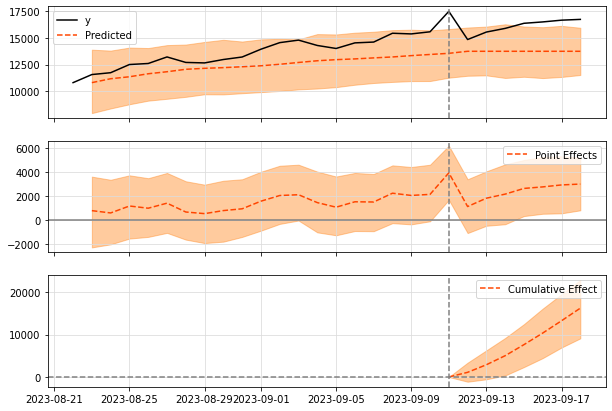

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. By contrast, in the absence of an
intervention, we would have expected an average response of 13733.38.
The 95% interval of this counterfactual prediction is [12706.33, 14761.2].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2319.34 with a 95% interval of
[1291.51, 3346.39]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 96133.63. The 95% interval of this prediction is [88944.28, 103328.4].


The above results are given in terms of absolute numbers. In relative
t

2023-10-13 06:57:56.146443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:57:56.191591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:57:57.199875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:

Исследуем колонку: uniq_users_per_day


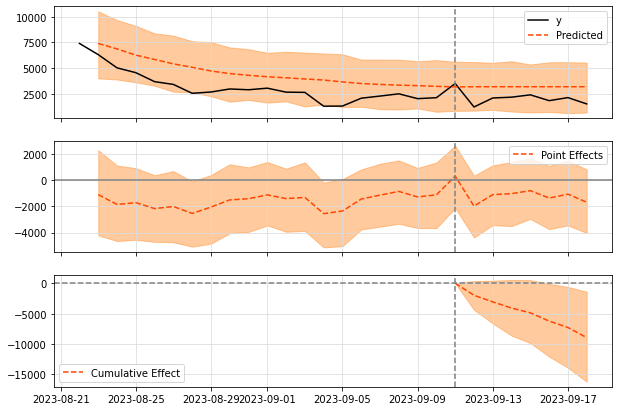

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1899.71. By contrast, in the absence of an
intervention, we would have expected an average response of 3180.03.
The 95% interval of this counterfactual prediction is [2086.96, 4231.7].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -1280.32 with a 95% interval of
[-2331.99, -187.25]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 13298.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 22260.22. The 95% interval of this prediction is [14608.74, 29621.93].


The above results are given in terms of absolute numbers. In relative
term

2023-10-13 06:58:26.131038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:58:26.175950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:58:27.120778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:

2023-10-13 06:58:51.658552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-10-13 06:58:51.838515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

Исследуем колонку: likes_per_user


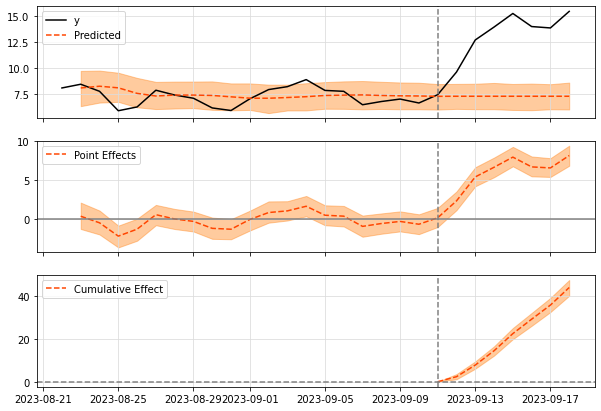

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 13.52. By contrast, in the absence of an
intervention, we would have expected an average response of 7.26.
The 95% interval of this counterfactual prediction is [6.73, 7.82].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 6.26 with a 95% interval of
[5.7, 6.79]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 94.65.
By contrast, had the intervention not taken place, we would have expected
a sum of 50.83. The 95% interval of this prediction is [47.1, 54.75].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an

2023-10-13 06:58:56.541488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:58:56.585061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:58:57.677905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:

Исследуем колонку: ctr


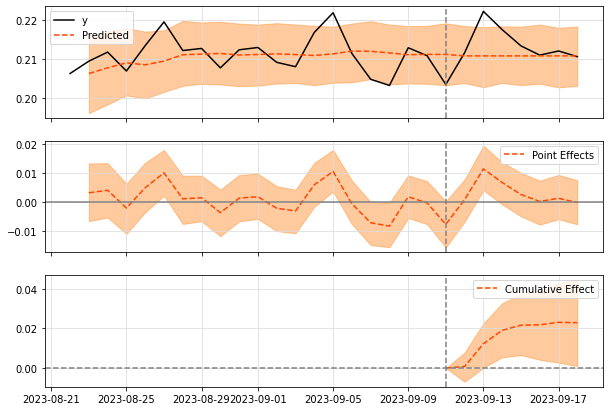

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. In the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.21, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.0 with a 95% interval of
[-0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
Had the intervention not taken place, we would have expected
a sum of 1.48. The 95% interval of this prediction is [1.45, 1.5].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +1.55%. The 95%
int

2023-10-13 06:59:28.277803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:59:28.314663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:59:29.475772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 06:

2023-10-13 06:59:55.305255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-10-13 06:59:55.509030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

Исследуем колонку: uniq_posts


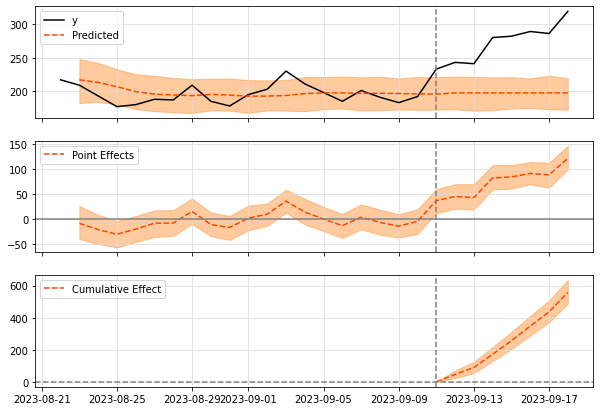

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 277.14. By contrast, in the absence of an
intervention, we would have expected an average response of 197.53.
The 95% interval of this counterfactual prediction is [187.43, 208.68].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 79.62 with a 95% interval of
[68.46, 89.72]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1940.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1382.68. The 95% interval of this prediction is [1311.99, 1460.79].


The above results are given in terms of absolute numbers. In relative
terms, the response

2023-10-13 06:59:59.951924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:00:00.014573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:00:01.548681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

2023-10-13 07:00:33.711412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-10-13 07:00:33.882071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

Исследуем колонку: uniq_posts_per_day


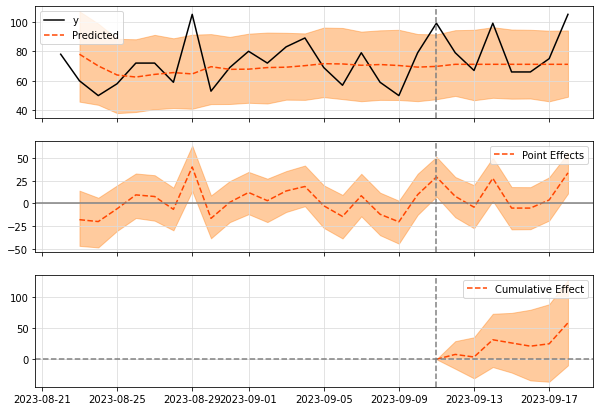

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 79.57. In the absence of an
intervention, we would have expected an average response of 71.17.
The 95% interval of this counterfactual prediction is [61.99, 81.45].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 8.4 with a 95% interval of
[-1.88, 17.58]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 557.0.
Had the intervention not taken place, we would have expected
a sum of 498.2. The 95% interval of this prediction is [433.91, 570.14].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +11.8

2023-10-13 07:00:38.369615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:00:38.406363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:00:39.527221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

Исследуем колонку: likes_per_post


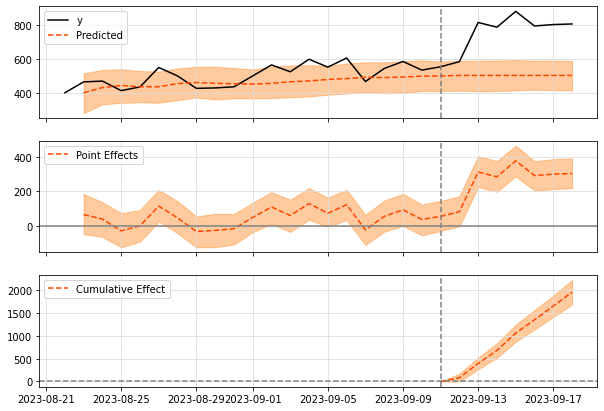

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 783.1. By contrast, in the absence of an
intervention, we would have expected an average response of 504.06.
The 95% interval of this counterfactual prediction is [464.14, 542.37].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 279.04 with a 95% interval of
[240.73, 318.96]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 5481.68.
By contrast, had the intervention not taken place, we would have expected
a sum of 3528.41. The 95% interval of this prediction is [3248.99, 3796.58].


The above results are given in terms of absolute numbers. In relative
terms, the respo

In [6]:
start(befor_flashmob, flashmob)

# Вывод по оценке флешмоба

    Почти все метрики показали значительное статистическое различие в сторону увеличения между измерениями до флешмоба и во время него(p-value <0,05). 
    
    Однако p-value показателя количества новых постов за день (uniq_posts_per_day) равен 5.39%, что не может говорить о сильной статистической разнице. Примечательно так же что количество новых пользователей, которые впервые зашли в приложение в дни флешмоба хоть и отличается от такового количества до этого эвента, но в меньшую стророну.

# Анализ переода после флешмоба

In [9]:
#индексируем датасет и выбираем даты до 11.09 и после флешмоба 19.09,
#прибавляя один день, для изолировании его влияния на последующий переод.

In [7]:
df=df.reset_index()
befor_flashmob = [0, 20]
after_flashmob = [29, 36]
print('Последняя дата до флешмоба ' + str(df.iloc[20].date))
print('Следующая дата после флешмоба ' + str(df.iloc[29].date))

Последняя дата до флешмоба 2023-09-11 00:00:00
Следующая дата после флешмоба 2023-09-20 00:00:00


2023-10-13 07:01:10.929738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:01:10.972951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:01:12.002693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

Исследуем колонку: uniq_users


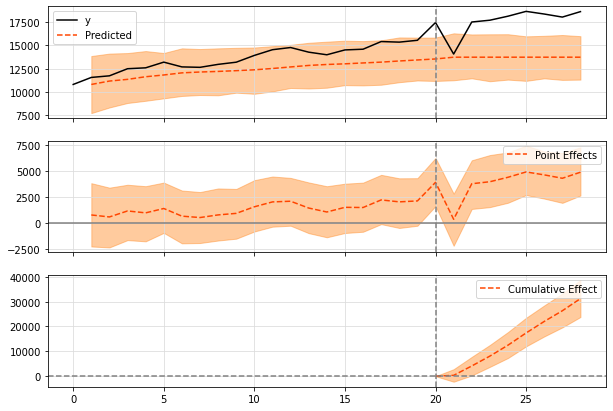

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 17637.12. By contrast, in the absence of an
intervention, we would have expected an average response of 13737.12.
The 95% interval of this counterfactual prediction is [12768.0, 14702.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 3900.0 with a 95% interval of
[2934.25, 4869.13]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 141097.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 109897.0. The 95% interval of this prediction is [102143.99, 117623.03].


The above results are given in terms of absolute numbers. In relative


2023-10-13 07:01:40.512030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:01:40.573894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:01:41.686974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

Исследуем колонку: uniq_users_per_day


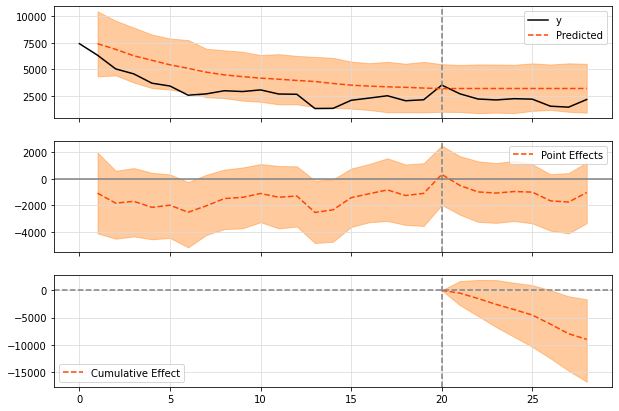

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2049.0. By contrast, in the absence of an
intervention, we would have expected an average response of 3175.13.
The 95% interval of this counterfactual prediction is [2189.58, 4071.82].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -1126.13 with a 95% interval of
[-2022.82, -140.58]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 16392.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 25401.06. The 95% interval of this prediction is [17516.61, 32574.59].


The above results are given in terms of absolute numbers. In relative
term

2023-10-13 07:02:11.563530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:02:11.620128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:02:12.671814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

Исследуем колонку: likes_per_user


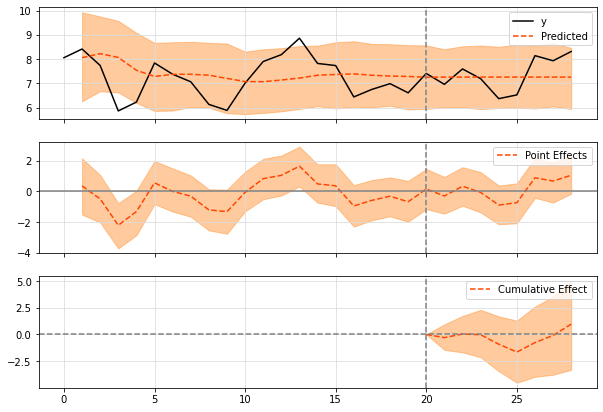

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 7.38. In the absence of an
intervention, we would have expected an average response of 7.26.
The 95% interval of this counterfactual prediction is [6.76, 7.79].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.12 with a 95% interval of
[-0.4, 0.62]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 59.05.
Had the intervention not taken place, we would have expected
a sum of 58.09. The 95% interval of this prediction is [54.07, 62.29].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +1.66%. The 

2023-10-13 07:02:40.994796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:02:41.041375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:02:42.099281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

Исследуем колонку: ctr


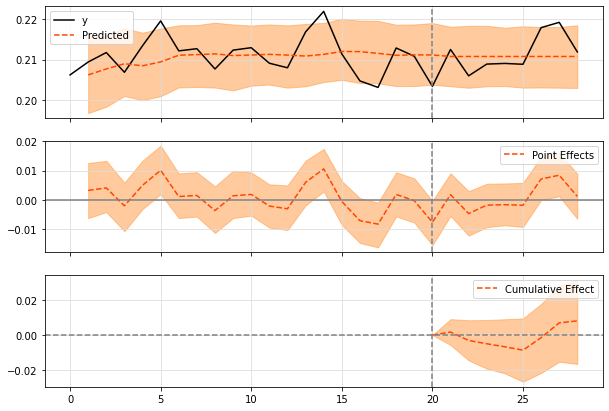

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. In the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.21, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.0 with a 95% interval of
[-0.0, 0.0]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.69.
Had the intervention not taken place, we would have expected
a sum of 1.69. The 95% interval of this prediction is [1.66, 1.71].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +0.48%. The 95%
in

2023-10-13 07:03:13.087208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:03:13.140133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:03:14.236162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

Исследуем колонку: uniq_posts


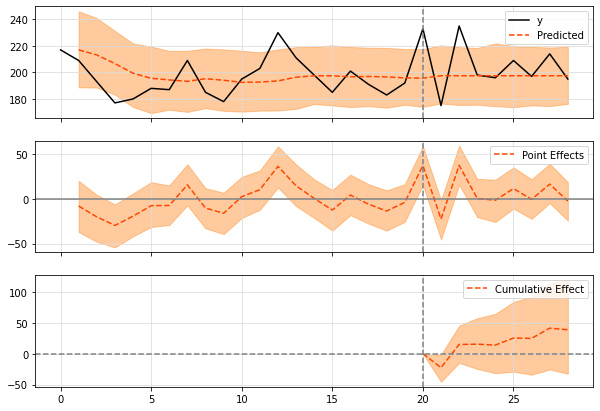

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 202.38. In the absence of an
intervention, we would have expected an average response of 197.51.
The 95% interval of this counterfactual prediction is [189.0, 206.79].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 4.86 with a 95% interval of
[-4.42, 13.38]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1619.0.
Had the intervention not taken place, we would have expected
a sum of 1580.1. The 95% interval of this prediction is [1512.0, 1654.36].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase o

2023-10-13 07:03:43.210409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:03:43.269369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:03:44.423924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

Исследуем колонку: uniq_posts_per_day


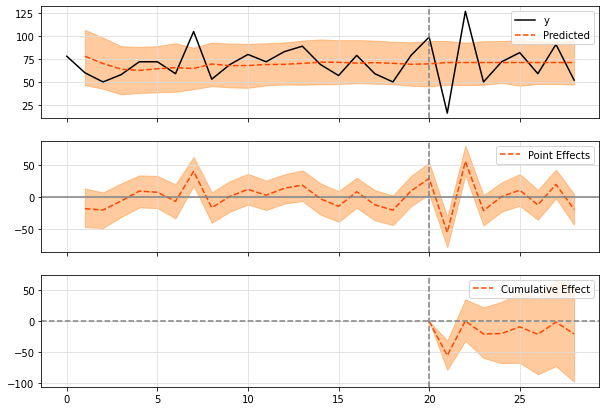

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 68.62. In the absence of an
intervention, we would have expected an average response of 71.17.
The 95% interval of this counterfactual prediction is [62.17, 80.79].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -2.55 with a 95% interval of
[-12.17, 6.45]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 549.0.
Had the intervention not taken place, we would have expected
a sum of 569.39. The 95% interval of this prediction is [497.37, 646.35].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -3.

2023-10-13 07:04:15.737101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:04:15.794654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:04:16.918107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-10-13 07:

Исследуем колонку: likes_per_post


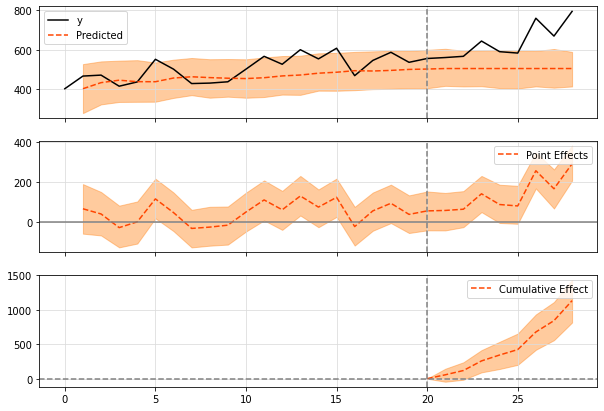

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 645.49. By contrast, in the absence of an
intervention, we would have expected an average response of 504.1.
The 95% interval of this counterfactual prediction is [462.2, 539.96].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 141.38 with a 95% interval of
[105.53, 183.29]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 5163.89.
By contrast, had the intervention not taken place, we would have expected
a sum of 4032.83. The 95% interval of this prediction is [3697.59, 4319.66].


The above results are given in terms of absolute numbers. In relative
terms, the respon

In [8]:
start(befor_flashmob, after_flashmob)

# Вывод по оценке времени после флешмоба

Показатели связанные с лайками: количество лайков на 1 человека (likes_per_user) и CTR(ctr) остались на прежнем уровне до эвента(p-value>0.05). 

Показатели связанные с постами: количество уникальных постов(uniq_posts) и новых постов в день(uniq_posts_per_day) так же остались на прежнем уровне до эвента(p-value>0.05).

Показатель среднего количества лайков на 1 пост и количество уникальных пользователей за день(MAO,uniq_users) стали статистически выше прежних значений. Напротив, количество новых пользователей(uniq_users_per_day) стало сокращаться. 


# Общий вывод

Флешмоб дал краткосрочный эффект по параметрамам связанным с лайками, которые вернулись на прежний уровень после этого эвента. 

Те показатели, которые имели тренд и до эвента (количество лайков на 1 пост, количество уникальных пользователей за день,количество новых пользователей) продолжили двигаться в том же направлении и после эвента. Поэтому необходима дальнейшая работа по определению вклада эвента в их тренды.(возможно использование коррелятов).